In [1]:
# Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import functools
from scipy.integrate import quad
from tensorflow.keras import regularizers

2024-12-09 18:43:36.823176: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Function used to Calculate the Magnetic Force at a Distance x
def FM(x):
    r = 1
    Mu = 1
    V = 1
    m = 1
    kB = 1
    Ms = 1
    T = 1

    coth = lambda x: 1 / np.tanh(x)

    S=1

    a5 = -2.5572964937676347e-05*(S**6)
    a4 = 0.002500536323288946*(S**5)
    a3 = -0.09537977589057538*(S**4)
    a2 = 1.7906115483904257*(S**3)
    a1 = -16.990318090784122*(S**2)
    a0 = 69.60547571766949*S

    Hs = a5 * x ** 5 + a4 * x ** 4 + a3 * x ** 3 + a2 * x ** 2 +a1 * x + a0
    abs_Hs = np.abs(Hs)
    coth_term = coth((Mu * m / (kB * T)) * abs_Hs)
    Mfit = Ms * (coth_term - (kB * T) / (Mu * m * abs_Hs)) * Hs / abs_Hs
    DH = 5 * a5 * x ** 4 + 4 * a4 * x ** 3 + 3 * a3 * x ** 2 + 2 * a2 * x + a1
    Fmx = -(V * Mu) * Mfit * DH

    return Fmx

# Function used to Calculate the Time towards the Target (via Numerical Integration)
def compute_time(z, r, Visc):
    time, _ = quad(lambda x: (6 * np.pi * r * Visc / FM(x)), 0, z)
    return time

In [3]:
# Define Problem Values
np.random.seed(42)
num_samples = 6
r = 1
Visc = 1
f = functools.partial(compute_time, r=1, Visc=1)
noise_level = 1E2

# Generate Training Data
x_train = np.linspace(15, 20, num_samples).reshape(-1, 1)
t_train = (np.array([f(x) for x in x_train]) + noise_level*np.random.normal(0, 1, num_samples)).reshape(-1, 1)
t_train_scaled = np.log(t_train).reshape(-1, 1)

# Convert to TensorFlow Tensors
x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
t_train_tf = tf.convert_to_tensor(t_train_scaled, dtype=tf.float32)
input_train = tf.concat([x_train_tf], axis=1)

# Generate Test Data for Prediction
x_test = np.linspace(0, 20, 1000).reshape(-1, 1)
t_exact = np.array([f(x) for x in x_test]).reshape(-1, 1)

# Convert to TensorFlow Tensors
x_test_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)
input_test = tf.concat([x_test_tf], axis=1)

In [4]:
# Define PINN Model
class PINN(tf.keras.Model):
    # Define PINN Architecture
    def __init__(self, neurons = 100):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(neurons, activation='gelu', input_dim=1)
        self.dense2 = tf.keras.layers.Dense(neurons, activation='gelu')
        self.dense3 = tf.keras.layers.Dense(neurons, activation='gelu')
        self.dense4 = tf.keras.layers.Dense(neurons, activation='gelu')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    # Define Feedforward Mechanism
    def call(self, inputs):
        x = inputs[:, 0:1]
        concat_input = tf.concat([x], axis=1)
        hidden1 = self.dense1(concat_input)
        hidden2 = self.dense2(hidden1)
        hidden3 = self.dense3(hidden2)
        hidden4 = self.dense4(hidden3)
        output = self.output_layer(hidden4)
        return output

In [5]:
# Function Used to Calculate Physics Loss
def physics_loss(model):
    x = np.linspace(0, 20, 1000).reshape(-1, 1)
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x)
        pred = model(x)
        dT = tape.gradient(pred, x)
    pde_residual = (6 * np.pi * r * Visc / FM(x)) - np.exp(pred)*dT
    return tf.reduce_mean(tf.square(pde_residual))

In [6]:
# Function Used to Train Model
def train_model(model, x_train, y_train, epochs=10000, data_loss_weight=1e0, phys_loss_weight=1e0):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1E-4)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            y_pred = model(input_train)
            data_loss = tf.reduce_mean(tf.square(y_pred - y_train))
            phys_loss = physics_loss(model)
            total_loss = data_loss_weight * data_loss + phys_loss_weight * phys_loss
        
        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if epoch % 50 == 0:
            print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.numpy()}, Physics Loss: {phys_loss.numpy()}, Data Loss: {data_loss.numpy()}")

In [7]:
# Instantiate and Train Model
model = PINN()
train_model(model, input_train, t_train_tf, epochs=4000)

/usr/local/Caskroom/miniconda/base/envs/pinn/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 0/4000, Total Loss: 4130.41943359375, Physics Loss: 4093.2666015625, Data Loss: 37.15299987792969
Epoch 50/4000, Total Loss: 681.0112915039062, Physics Loss: 679.3994140625, Data Loss: 1.6118496656417847
Epoch 100/4000, Total Loss: 366.3426513671875, Physics Loss: 365.6022644042969, Data Loss: 0.7403958439826965
Epoch 150/4000, Total Loss: 185.35751342773438, Physics Loss: 184.9956817626953, Data Loss: 0.3618345558643341
Epoch 200/4000, Total Loss: 84.3302993774414, Physics Loss: 84.21824645996094, Data Loss: 0.11205613613128662
Epoch 250/4000, Total Loss: 13.269932746887207, Physics Loss: 13.230591773986816, Data Loss: 0.03934058919548988
Epoch 300/4000, Total Loss: 12.463005065917969, Physics Loss: 12.43195915222168, Data Loss: 0.031046317890286446
Epoch 350/4000, Total Loss: 12.357667922973633, Physics Loss: 12.328689575195312, Data Loss: 0.02897869236767292
Epoch 400/4000, Total Loss: 11.942777633666992, Physics Loss: 11.91477108001709, Data Loss: 0.028006525710225105
Epoch 4

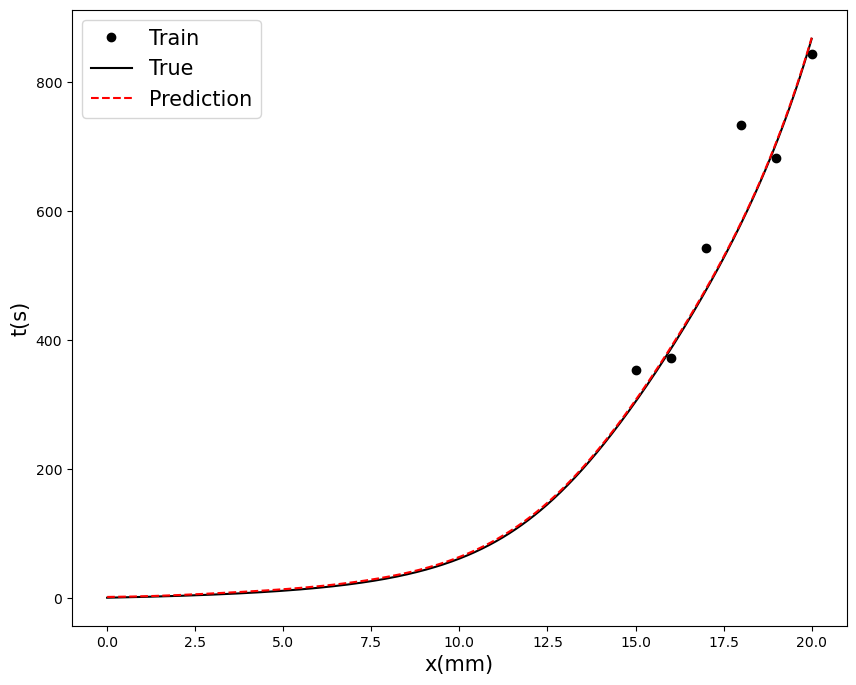

In [8]:
# Make Predictions for Entire Interval
t_pred = model(input_test)

# Plot Predictions
plt.figure(figsize = (10,8))
plt.plot(x_train, t_train, 'ok', label = 'Train')
#plt.plot(x_train, t_train_scaled, 'or', label = 'Scaled')
plt.plot(x_test, t_exact, '-k',label = 'True')
plt.plot(x_test, np.exp(t_pred), '--r', label = 'Prediction')
plt.legend(fontsize = 15)
plt.xlabel('x(mm)', fontsize = 15)
plt.ylabel('t(s)', fontsize = 15)
plt.show()